<a href="https://colab.research.google.com/github/Hayaalbaker/Dal-Comp/blob/main/Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Dates Classification

## Set Up

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
data_path = "/content/drive/My Drive/Dal Comp/open-data-day-2025-dates-types-classification"
print(os.listdir(data_path))

Mounted at /content/drive
['sample_submission.csv', 'train_labels.csv', 'test', 'train', 'Submission.ipynb']


In [4]:
import tensorflow as tf
print(tf.__version__)

2.18.0


       filename label
0  feda0fb2.jpg  Ajwa
1  f10703e9.png  Ajwa
2  04cdb8ab.jpg  Ajwa
3  56fa4cc4.jpg  Ajwa
4  e17feef7.jpg  Ajwa


<Axes: title={'center': 'Class Distribution'}, xlabel='label'>

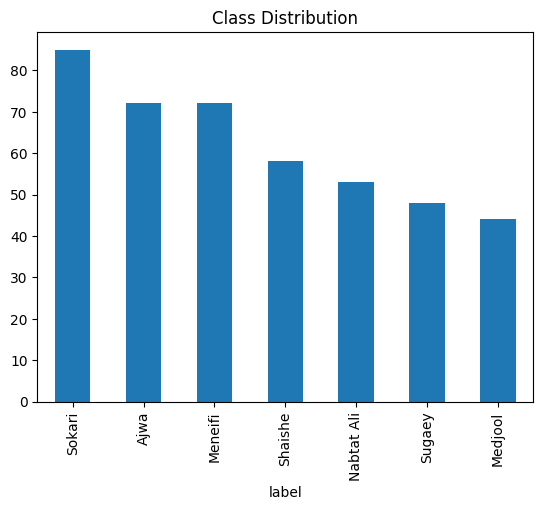

In [5]:
import pandas as pd

train_df = pd.read_csv(os.path.join(data_path, "train_labels.csv"))
print(train_df.head())

train_df['label'].value_counts().plot(kind='bar', title="Class Distribution")

## Data Preprocessing & Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_dataframe(
    train_df,
    directory=os.path.join(data_path, "train"),
    x_col="filename",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_dataframe(
    train_df,
    directory=os.path.join(data_path, "train"),
    x_col="filename",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 346 validated image filenames belonging to 7 classes.
Found 86 validated image filenames belonging to 7 classes.


In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,908,295 (91.20 MB)

 Trainable params: 23,908,295 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
from tensorflow.keras.layers import BatchNormalization

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    tf.keras.layers.Dense(len(train_gen.class_indices), activation='softmax')
])

In [47]:
import tensorflow as tf

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [48]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - accuracy: 0.1571 - loss: 3.5966 - val_accuracy: 0.1047 - val_loss: 2.0849 - learning_rate: 1.0000e-04
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.3154 - loss: 2.4459 - val_accuracy: 0.0698 - val_loss: 2.0256 - learning_rate: 1.0000e-04
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - accuracy: 0.4604 - loss: 1.6569 - val_accuracy: 0.0814 - val_loss: 2.0499 - learning_rate: 1.0000e-04
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.5931 - loss: 1.3258 - val_accuracy: 0.0116 - val_loss: 2.6315 - learning_rate: 1.0000e-04
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.6800 - loss: 0.9675 - val_accuracy: 0.0233 - val_loss: 2.8667 - learning_rate: 1.0000e-04
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 75s 6s/step - accuracy: 0.6598 - loss: 0.9291 - val_accuracy: 0.0116 - val_loss: 3.0703 - learning_rate: 2.0000e-05
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.7168 - loss:

In [50]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_labels = pd.read_csv("/content/drive/MyDrive/Dal Comp/open-data-day-2025-dates-types-classification/train_labels.csv")

balanced_val_df = train_labels.groupby("label").apply(lambda x: x.sample(n=20, replace=True)).reset_index(drop=True)

print(balanced_val_df['label'].value_counts())

label
Ajwa          20
Medjool       20
Meneifi       20
Nabtat Ali    20
Shaishe       20
Sokari        20
Sugaey        20
Name: count, dtype: int64


<ipython-input-50-0ffa96a0dd05>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_val_df = train_labels.groupby("label").apply(lambda x: x.sample(n=20, replace=True)).reset_index(drop=True)


In [51]:
import pandas as pd

train_labels = pd.read_csv("/content/drive/MyDrive/Dal Comp/open-data-day-2025-dates-types-classification/train_labels.csv")

train_class_counts = train_labels["label"].value_counts()

print("Training Class Distribution:\n", train_class_counts)

Training Class Distribution:
 label
Sokari        85
Ajwa          72
Meneifi       72
Shaishe       58
Nabtat Ali    53
Sugaey        48
Medjool       44
Name: count, dtype: int64


In [52]:
from sklearn.utils import resample

max_count = train_class_counts.max()

balanced_dfs = []
for label, group in train_labels.groupby('label'):
    balanced_dfs.append(group.sample(max_count, replace=True))

train_df_balanced = pd.concat(balanced_dfs)
train_df_balanced = train_df_balanced.sample(frac=1).reset_index(drop=True)

print(train_df_balanced['label'].value_counts())

label
Meneifi       85
Sugaey        85
Ajwa          85
Shaishe       85
Medjool       85
Sokari        85
Nabtat Ali    85
Name: count, dtype: int64


In [54]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

In [55]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.4910 - loss: 1.6862 - val_accuracy: 0.1047 - val_loss: 1.9688 - learning_rate: 2.0000e-05
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.5035 - loss: 1.5964 - val_accuracy: 0.0930 - val_loss: 2.0107 - learning_rate: 2.0000e-05
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.4556 - loss: 1.6305 - val_accuracy: 0.1395 - val_loss: 1.9385 - learning_rate: 2.0000e-05
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.5422 - loss: 1.3102 - val_accuracy: 0.1860 - val_loss: 1.9990 - learning_rate: 2.0000e-05
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.5954 - loss: 1.1190 - val_accuracy: 0.1744 - val_loss: 2.0483 - learning_rate: 2.0000e-05
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - accuracy: 0.6528 - loss: 1.0516 - val_accuracy: 0.1163 - val_loss: 2.0462 - learning_rate: 2.0000e-05
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.5815 - loss: